# Install MMSegmentation

In [5]:
!nvidia-smi # Tesla P100이 출력되지 않으면 "런타임 초기화"

Tue Jul 25 12:02:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   54C    P8    16W / 300W |    795MiB / 11176MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.12.1 True


In [3]:
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html


In [4]:
!rm -rf mmsegmentation
!git clone https://github.com/museonghwang/mmsegmentation.git
#!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation

!pip install -e .
%cd ..

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7003, done.
remote: Total 7003 (delta 0), reused 0 (delta 0), pack-reused 7003
Receiving objects: 100% (7003/7003), 12.82 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (5187/5187), done.
/home/cuvic/satellite/RealSegformer/mmsegmentation
Obtaining file:///home/cuvic/satellite/RealSegformer/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [6]:
# 런타임 -> 런타임 "다시 시작" 후 아래 수행. 
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.1 True
0.24.1


# Run Inference with MMSeg trained weight

In [7]:
%cd mmsegmentation
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth -P checkpoints
%cd ..

/home/cuvic/satellite/RealSegformer/mmsegmentation
--2023-07-25 09:53:43--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.22.217, 163.181.22.211, 163.181.22.210, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.22.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

segformer_mit-b5_8x 100%[===================>] 313.08M  19.9MB/s    in 18s     

2023-07-25 09:54:01 (17.8 MB/s) - ‘checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]

/home/cuvic/satellite/RealSegformer


In [7]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [8]:
config_file = 'mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = 'mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

In [9]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth


In [ ]:
# test a single image
img = 'mmsegmentation/demo/demo.png'
result = inference_segmentor(model, img)

/home/cuvic/satellite/RealSegformer/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


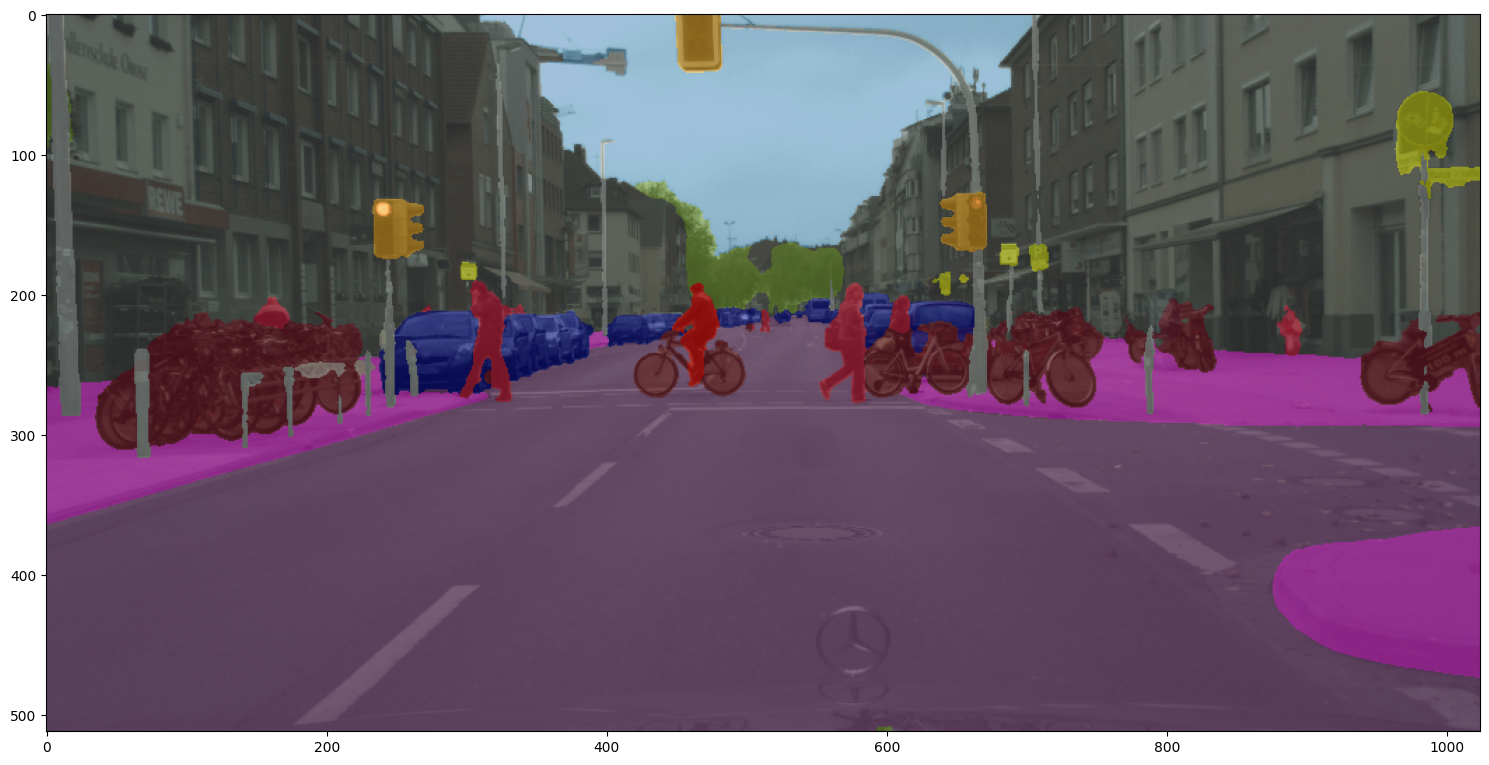

In [6]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

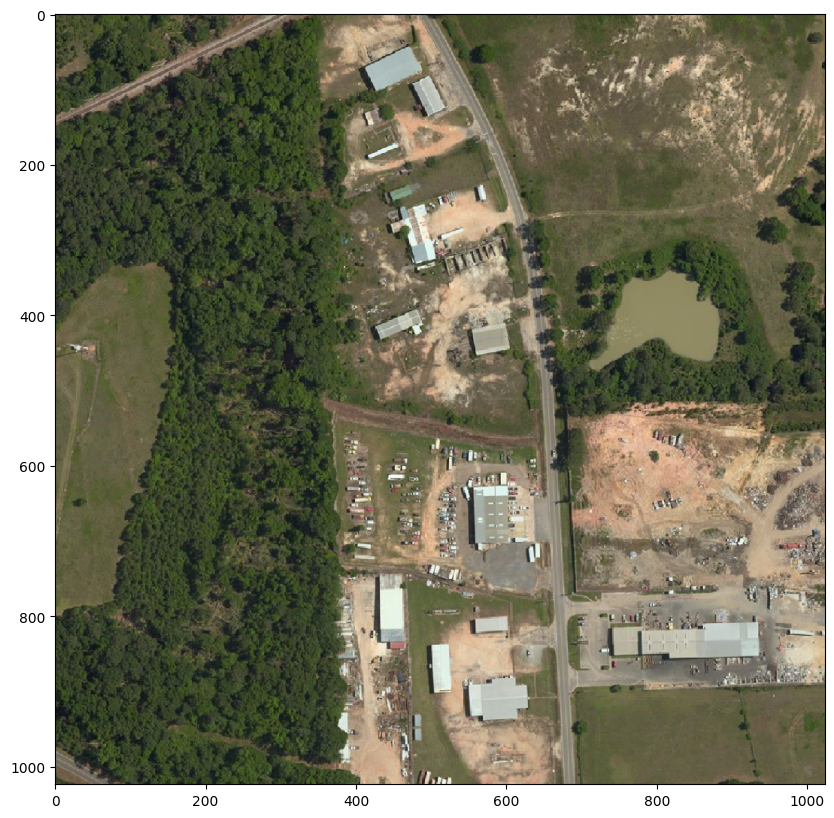

In [10]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('./TRAIN_1000.png')
plt.figure(figsize=(10, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [11]:
import os.path as osp
import numpy as np
from PIL import Image
import cv2

# convert dataset annotation to semantic segmentation map
data_root = '.'
img_dir = 'train_img'
ann_dir = 'result'

# define class and plaette for better visualization
classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 255]]

In [12]:
    # RLE 디코딩 함수
    def rle_decode(mask_rle, shape):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 255
        return img.reshape(shape)

    # RLE 인코딩 함수
    def rle_encode(mask):
        pixels = mask.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        return ' '.join(str(x) for x in runs)

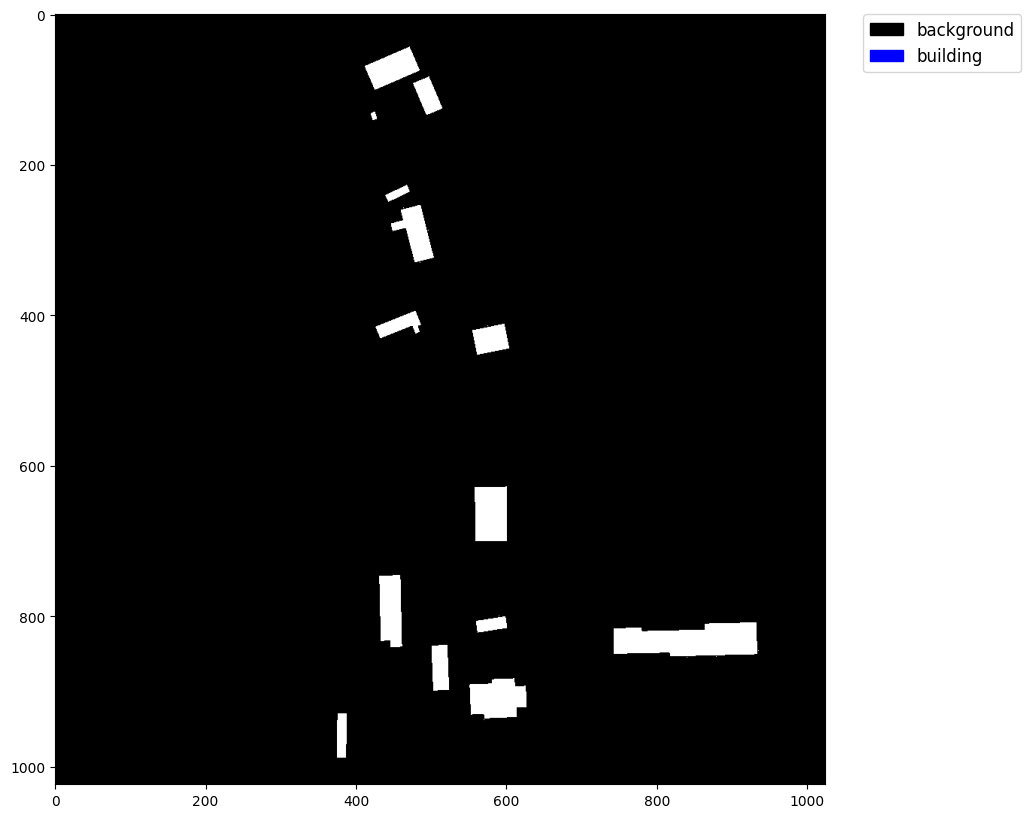

In [13]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
import pandas as pd

csv_file = 'train.csv'

data = pd.read_csv(csv_file)

mask_rle = data.iloc[1000, 2]

mask = rle_decode(mask_rle, (1024, 1024))

mask = Image.fromarray(mask)

img = mask
plt.figure(figsize=(10, 10))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(2)]

# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()

# Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [14]:
config_file = 'mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = 'mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'
save_pth_path = 'mmsegmentation/building_checkpoint'

In [15]:
# convert dataset annotation to semantic segmentation map
data_root = '.'
img_dir = 'train_img'
ann_dir = 'mask_img'

# define class and plaette for better visualization
classes = ('background', 'building')
palette = [[0, 0, 0], [0, 0, 255]]

In [16]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module(force=True)
class RoadSemanticSegmentation(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [19]:
from mmcv import Config

cfg = Config.fromfile(config_file)

In [20]:
from mmseg.apis import set_random_seed

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
    CLASSES=classes,
    PALETTE=palette)

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2

# modify loss function crossentropy
cfg.model.decode_head.loss_decode= [dict(type='CrossEntropyLoss', class_weight=[0.5, 1.0], loss_name='loss_ce', loss_weight=0.8),
									dict(type='LovaszLoss', loss_type='multi_class', classes='all', per_image=True, reduction='mean', class_weight=[0.5, 1.0], loss_name='loss_lovasz', loss_weight=0.2)]

#cfg.model.test_cfg.mode = 'whole'
#del cfg['model']['test_cfg']['crop_size']
#del cfg['model']['test_cfg']['stride']

# Modify dataset type and path
cfg.dataset_type = 'RoadSemanticSegmentation'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

# Albumentations transforms settings
albu_train_transforms = [
    dict(
    type='OneOf',
    transforms=[
        dict(type='RandomRotate90', p=1.0)
    ], p=0.5),

    dict(
    type='OneOf',
    transforms=[
        dict(type='RandomBrightnessContrast',brightness_limit=0.2, contrast_limit=0.3, p=1.0),
        dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=1.0),
        dict(type='HueSaturationValue', hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=15, p=1.0),
    ], p=0.5)
]

# pipline
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        keymap=dict(img='image', gt_semantic_seg='mask'),
        update_pad_shape=True,
        ),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = '.'
cfg.data.train.img_dir = 'train_img'
cfg.data.train.ann_dir = 'mask_img'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'split/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = '.'
cfg.data.val.img_dir = 'train_img'
cfg.data.val.ann_dir = 'mask_img'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'split/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = '.'
cfg.data.test.img_dir = 'train_img'
cfg.data.test.ann_dir = 'mask_img'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'split/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = save_pth_path

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = 500
cfg.evaluation.save_best = 'mIoU'
cfg.checkpoint_config.interval = 500

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = [0]

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(
                type='CrossEntropyLoss',
                class_weight=[0.5

# Train and Evaluation

In [21]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

2023-07-25 12:03:40,709 - mmseg - INFO - Loaded 6426 images


In [22]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

/home/cuvic/satellite/RealSegformer/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [23]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

2023-07-25 12:03:42,644 - mmseg - INFO - Loaded 714 images
2023-07-25 12:03:42,645 - mmseg - INFO - load checkpoint from local path: mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2023-07-25 12:03:42,919 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2023-07-25 12:03:42,920 - mmseg - INFO - Start running, host: cuvic@lake63, work_dir: /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint
2023-07-25 12:03:42,921 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHoo

2023-07-25 12:12:53,000 - mmseg - INFO - Iter [240/10000]	lr: 9.332e-06, eta: 6:12:42, time: 2.293, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0996, decode.loss_lovasz: 0.0625, decode.acc_seg: 95.7918, loss: 0.1621
2023-07-25 12:13:15,956 - mmseg - INFO - Iter [250/10000]	lr: 9.712e-06, eta: 6:12:21, time: 2.296, data_time: 0.006, memory: 9685, decode.loss_ce: 0.1007, decode.loss_lovasz: 0.0616, decode.acc_seg: 95.1422, loss: 0.1623
2023-07-25 12:13:38,936 - mmseg - INFO - Iter [260/10000]	lr: 1.009e-05, eta: 6:12:00, time: 2.298, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0818, decode.loss_lovasz: 0.0614, decode.acc_seg: 96.5617, loss: 0.1432
2023-07-25 12:14:01,902 - mmseg - INFO - Iter [270/10000]	lr: 1.047e-05, eta: 6:11:39, time: 2.297, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0860, decode.loss_lovasz: 0.0623, decode.acc_seg: 95.7747, loss: 0.1482
2023-07-25 12:14:24,876 - mmseg - INFO - Iter [280/10000]	lr: 1.085e-05, eta: 6:11:18, time: 2.297, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3275s, ETA:     0s

2023-07-25 13:17:28,709 - mmseg - INFO - per class results:
2023-07-25 13:17:28,710 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 96.98 | 98.08 |
|  building  | 62.09 | 81.57 |
+------------+-------+-------+
2023-07-25 13:17:28,710 - mmseg - INFO - Summary:
2023-07-25 13:17:28,711 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.12 | 79.54 | 89.82 |
+-------+-------+-------+
2023-07-25 13:17:30,264 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_500.pth.
2023-07-25 13:17:30,264 - mmseg - INFO - Best mIoU is 0.7954 at 500 iter.
2023-07-25 13:17:30,266 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9712, mIoU: 0.7954, mAcc: 0.8982, IoU.background: 0.9698, IoU.building: 0.6209, Acc.background: 0.9808, Acc.building: 0.8157
2023-07-25 13:17:53,688 - mmseg - INFO - Iter [510/10000]	lr: 1.932e-05, eta: 23:00:15, time: 330.048, data_time: 327.711, memory

2023-07-25 13:30:32,534 - mmseg - INFO - Iter [840/10000]	lr: 3.074e-05, eta: 15:46:47, time: 2.297, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0360, decode.loss_lovasz: 0.0477, decode.acc_seg: 97.5947, loss: 0.0837
2023-07-25 13:30:55,464 - mmseg - INFO - Iter [850/10000]	lr: 3.108e-05, eta: 15:38:44, time: 2.293, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0373, decode.loss_lovasz: 0.0453, decode.acc_seg: 97.7339, loss: 0.0826
2023-07-25 13:31:18,431 - mmseg - INFO - Iter [860/10000]	lr: 3.141e-05, eta: 15:30:53, time: 2.297, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0385, decode.loss_lovasz: 0.0510, decode.acc_seg: 97.3236, loss: 0.0896
2023-07-25 13:31:41,375 - mmseg - INFO - Iter [870/10000]	lr: 3.174e-05, eta: 15:23:11, time: 2.294, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0485, decode.loss_lovasz: 0.0447, decode.acc_seg: 96.6755, loss: 0.0932
2023-07-25 13:32:04,333 - mmseg - INFO - Iter [880/10000]	lr: 3.207e-05, eta: 15:15:39, time: 2.296, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3291s, ETA:     0s

2023-07-25 14:31:32,770 - mmseg - INFO - per class results:
2023-07-25 14:31:32,771 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.29 | 98.13 |
|  building  |  65.8 | 85.89 |
+------------+-------+-------+
2023-07-25 14:31:32,771 - mmseg - INFO - Summary:
2023-07-25 14:31:32,772 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.42 | 81.55 | 92.01 |
+-------+-------+-------+
2023-07-25 14:31:32,847 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_500.pth was removed
2023-07-25 14:31:34,335 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_1000.pth.
2023-07-25 14:31:34,336 - mmseg - INFO - Best mIoU is 0.8155 at 1000 iter.
2023-07-25 14:31:34,338 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9742, mIoU: 0.8155, mAcc: 0.9201, IoU.background: 0.9729, IoU.building: 0.65

2023-07-25 14:44:14,304 - mmseg - INFO - Iter [1330/10000]	lr: 4.610e-05, eta: 17:26:23, time: 2.302, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0367, decode.loss_lovasz: 0.0396, decode.acc_seg: 97.7012, loss: 0.0763
2023-07-25 14:44:37,315 - mmseg - INFO - Iter [1340/10000]	lr: 4.639e-05, eta: 17:19:52, time: 2.301, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0364, decode.loss_lovasz: 0.0396, decode.acc_seg: 97.5371, loss: 0.0761
2023-07-25 14:45:00,350 - mmseg - INFO - Iter [1350/10000]	lr: 4.668e-05, eta: 17:13:25, time: 2.304, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0413, decode.loss_lovasz: 0.0383, decode.acc_seg: 97.2001, loss: 0.0796
2023-07-25 14:45:23,387 - mmseg - INFO - Iter [1360/10000]	lr: 4.697e-05, eta: 17:07:05, time: 2.304, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0601, decode.loss_lovasz: 0.0439, decode.acc_seg: 96.2628, loss: 0.1040
2023-07-25 14:45:46,303 - mmseg - INFO - Iter [1370/10000]	lr: 4.726e-05, eta: 17:00:48, time: 2.292, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3287s, ETA:     0s

2023-07-25 15:45:33,914 - mmseg - INFO - per class results:
2023-07-25 15:45:33,915 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.82 | 98.93 |
|  building  | 69.31 | 81.43 |
+------------+-------+-------+
2023-07-25 15:45:33,915 - mmseg - INFO - Summary:
2023-07-25 15:45:33,916 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.92 | 83.56 | 90.18 |
+-------+-------+-------+
2023-07-25 15:45:33,988 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_1000.pth was removed
2023-07-25 15:45:35,418 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_1500.pth.
2023-07-25 15:45:35,418 - mmseg - INFO - Best mIoU is 0.8356 at 1500 iter.
2023-07-25 15:45:35,420 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9792, mIoU: 0.8356, mAcc: 0.9018, IoU.background: 0.9782, IoU.building: 0.6

2023-07-25 15:58:17,632 - mmseg - INFO - Iter [1830/10000]	lr: 4.903e-05, eta: 17:27:15, time: 2.297, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0311, decode.loss_lovasz: 0.0358, decode.acc_seg: 97.8739, loss: 0.0669
2023-07-25 15:58:40,559 - mmseg - INFO - Iter [1840/10000]	lr: 4.897e-05, eta: 17:21:59, time: 2.293, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0304, decode.loss_lovasz: 0.0385, decode.acc_seg: 98.1001, loss: 0.0689
2023-07-25 15:59:03,586 - mmseg - INFO - Iter [1850/10000]	lr: 4.891e-05, eta: 17:16:46, time: 2.303, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0356, decode.loss_lovasz: 0.0366, decode.acc_seg: 97.4230, loss: 0.0722
2023-07-25 15:59:26,644 - mmseg - INFO - Iter [1860/10000]	lr: 4.885e-05, eta: 17:11:36, time: 2.306, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0445, decode.loss_lovasz: 0.0377, decode.acc_seg: 97.2199, loss: 0.0822
2023-07-25 15:59:49,722 - mmseg - INFO - Iter [1870/10000]	lr: 4.879e-05, eta: 17:06:30, time: 2.308, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3281s, ETA:     0s

2023-07-25 16:59:31,380 - mmseg - INFO - per class results:
2023-07-25 16:59:31,380 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.75 | 98.46 |
|  building  | 70.47 | 88.22 |
+------------+-------+-------+
2023-07-25 16:59:31,381 - mmseg - INFO - Summary:
2023-07-25 16:59:31,381 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.87 | 84.11 | 93.34 |
+-------+-------+-------+
2023-07-25 16:59:31,458 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_1500.pth was removed
2023-07-25 16:59:32,890 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_2000.pth.
2023-07-25 16:59:32,890 - mmseg - INFO - Best mIoU is 0.8411 at 2000 iter.
2023-07-25 16:59:32,892 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9787, mIoU: 0.8411, mAcc: 0.9334, IoU.background: 0.9775, IoU.building: 0.7

2023-07-25 17:12:07,926 - mmseg - INFO - Iter [2330/10000]	lr: 4.603e-05, eta: 16:55:14, time: 2.286, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0365, decode.loss_lovasz: 0.0415, decode.acc_seg: 97.4647, loss: 0.0780
2023-07-25 17:12:30,743 - mmseg - INFO - Iter [2340/10000]	lr: 4.597e-05, eta: 16:50:50, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0352, decode.loss_lovasz: 0.0339, decode.acc_seg: 97.5505, loss: 0.0692
2023-07-25 17:12:53,586 - mmseg - INFO - Iter [2350/10000]	lr: 4.591e-05, eta: 16:46:27, time: 2.284, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0295, decode.loss_lovasz: 0.0374, decode.acc_seg: 97.9463, loss: 0.0668
2023-07-25 17:13:16,416 - mmseg - INFO - Iter [2360/10000]	lr: 4.585e-05, eta: 16:42:07, time: 2.283, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0339, decode.loss_lovasz: 0.0329, decode.acc_seg: 97.8170, loss: 0.0668
2023-07-25 17:13:39,255 - mmseg - INFO - Iter [2370/10000]	lr: 4.579e-05, eta: 16:37:48, time: 2.284, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3228s, ETA:     0s

2023-07-25 18:12:25,764 - mmseg - INFO - per class results:
2023-07-25 18:12:25,764 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  97.9 | 98.59 |
|  building  | 71.91 | 88.51 |
+------------+-------+-------+
2023-07-25 18:12:25,764 - mmseg - INFO - Summary:
2023-07-25 18:12:25,765 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 98.0 | 84.9 | 93.55 |
+------+------+-------+
2023-07-25 18:12:25,836 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_2000.pth was removed
2023-07-25 18:12:27,329 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_2500.pth.
2023-07-25 18:12:27,330 - mmseg - INFO - Best mIoU is 0.8490 at 2500 iter.
2023-07-25 18:12:27,332 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9800, mIoU: 0.8490, mAcc: 0.9355, IoU.background: 0.9790, IoU.building: 0.7191, Acc.b

2023-07-25 18:25:00,762 - mmseg - INFO - Iter [2830/10000]	lr: 4.303e-05, eta: 16:06:02, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0396, decode.loss_lovasz: 0.0429, decode.acc_seg: 97.2846, loss: 0.0826
2023-07-25 18:25:23,559 - mmseg - INFO - Iter [2840/10000]	lr: 4.297e-05, eta: 16:02:14, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0345, decode.loss_lovasz: 0.0370, decode.acc_seg: 97.4830, loss: 0.0714
2023-07-25 18:25:46,363 - mmseg - INFO - Iter [2850/10000]	lr: 4.291e-05, eta: 15:58:29, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0314, decode.loss_lovasz: 0.0328, decode.acc_seg: 97.9432, loss: 0.0642
2023-07-25 18:26:09,181 - mmseg - INFO - Iter [2860/10000]	lr: 4.285e-05, eta: 15:54:44, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0513, decode.loss_lovasz: 0.0358, decode.acc_seg: 97.3508, loss: 0.0870
2023-07-25 18:26:31,980 - mmseg - INFO - Iter [2870/10000]	lr: 4.279e-05, eta: 15:51:01, time: 2.280, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3208s, ETA:     0s

2023-07-25 19:24:57,811 - mmseg - INFO - per class results:
2023-07-25 19:24:57,812 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.94 |  98.6 |
|  building  | 72.43 | 88.95 |
+------------+-------+-------+
2023-07-25 19:24:57,812 - mmseg - INFO - Summary:
2023-07-25 19:24:57,813 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.05 | 85.19 | 93.78 |
+-------+-------+-------+
2023-07-25 19:24:57,890 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_2500.pth was removed
2023-07-25 19:24:59,372 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_3000.pth.
2023-07-25 19:24:59,373 - mmseg - INFO - Best mIoU is 0.8519 at 3000 iter.
2023-07-25 19:24:59,375 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9805, mIoU: 0.8519, mAcc: 0.9378, IoU.background: 0.9794, IoU.building: 0.7

2023-07-25 19:37:34,847 - mmseg - INFO - Iter [3330/10000]	lr: 4.003e-05, eta: 15:09:05, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0343, decode.loss_lovasz: 0.0382, decode.acc_seg: 97.5757, loss: 0.0725
2023-07-25 19:37:57,667 - mmseg - INFO - Iter [3340/10000]	lr: 3.997e-05, eta: 15:05:45, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0285, decode.loss_lovasz: 0.0408, decode.acc_seg: 98.0087, loss: 0.0693
2023-07-25 19:38:20,440 - mmseg - INFO - Iter [3350/10000]	lr: 3.991e-05, eta: 15:02:27, time: 2.277, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0356, decode.loss_lovasz: 0.0358, decode.acc_seg: 97.4224, loss: 0.0714
2023-07-25 19:38:43,246 - mmseg - INFO - Iter [3360/10000]	lr: 3.985e-05, eta: 14:59:10, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0435, decode.loss_lovasz: 0.0364, decode.acc_seg: 97.1602, loss: 0.0799
2023-07-25 19:39:06,056 - mmseg - INFO - Iter [3370/10000]	lr: 3.979e-05, eta: 14:55:53, time: 2.281, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3206s, ETA:     0s

2023-07-25 20:37:30,244 - mmseg - INFO - per class results:
2023-07-25 20:37:30,245 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 97.97 | 98.72 |
|  building  | 72.38 |  87.5 |
+------------+-------+-------+
2023-07-25 20:37:30,245 - mmseg - INFO - Summary:
2023-07-25 20:37:30,245 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.07 | 85.17 | 93.11 |
+-------+-------+-------+
2023-07-25 20:37:30,247 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9807, mIoU: 0.8517, mAcc: 0.9311, IoU.background: 0.9797, IoU.building: 0.7238, Acc.background: 0.9872, Acc.building: 0.8750
2023-07-25 20:37:53,513 - mmseg - INFO - Iter [3510/10000]	lr: 3.895e-05, eta: 15:50:42, time: 322.963, data_time: 320.643, memory: 9685, decode.loss_ce: 0.0306, decode.loss_lovasz: 0.0377, decode.acc_seg: 97.8366, loss: 0.0683
2023-07-25 20:38:16,519 - mmseg - INFO - Iter [3520/10000]	lr: 3.889e-05

2023-07-25 20:50:49,020 - mmseg - INFO - Iter [3850/10000]	lr: 3.691e-05, eta: 14:01:59, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0266, decode.loss_lovasz: 0.0383, decode.acc_seg: 98.2770, loss: 0.0649
2023-07-25 20:51:11,832 - mmseg - INFO - Iter [3860/10000]	lr: 3.685e-05, eta: 13:59:02, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0298, decode.loss_lovasz: 0.0324, decode.acc_seg: 97.9070, loss: 0.0622
2023-07-25 20:51:34,659 - mmseg - INFO - Iter [3870/10000]	lr: 3.679e-05, eta: 13:56:06, time: 2.283, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0309, decode.loss_lovasz: 0.0350, decode.acc_seg: 97.8913, loss: 0.0659
2023-07-25 20:51:57,474 - mmseg - INFO - Iter [3880/10000]	lr: 3.673e-05, eta: 13:53:12, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0314, decode.loss_lovasz: 0.0404, decode.acc_seg: 97.9793, loss: 0.0718
2023-07-25 20:52:20,262 - mmseg - INFO - Iter [3890/10000]	lr: 3.667e-05, eta: 13:50:17, time: 2.279, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3205s, ETA:     0s

2023-07-25 21:49:57,752 - mmseg - INFO - per class results:
2023-07-25 21:49:57,753 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.07 | 98.75 |
|  building  | 73.65 | 88.73 |
+------------+-------+-------+
2023-07-25 21:49:57,753 - mmseg - INFO - Summary:
2023-07-25 21:49:57,754 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.17 | 85.86 | 93.74 |
+-------+-------+-------+
2023-07-25 21:49:57,829 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_3000.pth was removed
2023-07-25 21:49:59,302 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_4000.pth.
2023-07-25 21:49:59,303 - mmseg - INFO - Best mIoU is 0.8586 at 4000 iter.
2023-07-25 21:49:59,305 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9817, mIoU: 0.8586, mAcc: 0.9374, IoU.background: 0.9807, IoU.building: 0.7

2023-07-25 22:02:32,337 - mmseg - INFO - Iter [4330/10000]	lr: 3.403e-05, eta: 13:04:08, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0360, decode.loss_lovasz: 0.0404, decode.acc_seg: 97.6690, loss: 0.0764
2023-07-25 22:02:55,119 - mmseg - INFO - Iter [4340/10000]	lr: 3.397e-05, eta: 13:01:26, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0273, decode.loss_lovasz: 0.0324, decode.acc_seg: 97.9255, loss: 0.0598
2023-07-25 22:03:17,928 - mmseg - INFO - Iter [4350/10000]	lr: 3.391e-05, eta: 12:58:45, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0335, decode.loss_lovasz: 0.0365, decode.acc_seg: 97.8663, loss: 0.0700
2023-07-25 22:03:40,702 - mmseg - INFO - Iter [4360/10000]	lr: 3.385e-05, eta: 12:56:05, time: 2.277, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0324, decode.loss_lovasz: 0.0383, decode.acc_seg: 97.7687, loss: 0.0708
2023-07-25 22:04:03,464 - mmseg - INFO - Iter [4370/10000]	lr: 3.379e-05, eta: 12:53:26, time: 2.276, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3204s, ETA:     0s

2023-07-25 23:02:25,471 - mmseg - INFO - per class results:
2023-07-25 23:02:25,472 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.11 | 98.79 |
|  building  |  74.0 | 88.56 |
+------------+-------+-------+
2023-07-25 23:02:25,472 - mmseg - INFO - Summary:
2023-07-25 23:02:25,472 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 98.2 | 86.05 | 93.68 |
+------+-------+-------+
2023-07-25 23:02:25,546 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_4000.pth was removed
2023-07-25 23:02:27,019 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_4500.pth.
2023-07-25 23:02:27,019 - mmseg - INFO - Best mIoU is 0.8605 at 4500 iter.
2023-07-25 23:02:27,021 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9820, mIoU: 0.8605, mAcc: 0.9368, IoU.background: 0.9811, IoU.building: 0.7400, 

2023-07-25 23:15:02,555 - mmseg - INFO - Iter [4830/10000]	lr: 3.103e-05, eta: 11:58:34, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0319, decode.loss_lovasz: 0.0361, decode.acc_seg: 97.7488, loss: 0.0681
2023-07-25 23:15:25,362 - mmseg - INFO - Iter [4840/10000]	lr: 3.097e-05, eta: 11:56:06, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0368, decode.loss_lovasz: 0.0458, decode.acc_seg: 97.6257, loss: 0.0826
2023-07-25 23:15:48,147 - mmseg - INFO - Iter [4850/10000]	lr: 3.091e-05, eta: 11:53:39, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0329, decode.loss_lovasz: 0.0363, decode.acc_seg: 97.6820, loss: 0.0693
2023-07-25 23:16:10,966 - mmseg - INFO - Iter [4860/10000]	lr: 3.085e-05, eta: 11:51:12, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0352, decode.loss_lovasz: 0.0329, decode.acc_seg: 97.5742, loss: 0.0681
2023-07-25 23:16:33,756 - mmseg - INFO - Iter [4870/10000]	lr: 3.079e-05, eta: 11:48:45, time: 2.279, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3201s, ETA:     0s

2023-07-26 00:14:52,120 - mmseg - INFO - per class results:
2023-07-26 00:14:52,121 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.03 | 98.64 |
|  building  | 73.56 | 89.85 |
+------------+-------+-------+
2023-07-26 00:14:52,121 - mmseg - INFO - Summary:
2023-07-26 00:14:52,122 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.14 | 85.79 | 94.25 |
+-------+-------+-------+
2023-07-26 00:14:52,124 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9814, mIoU: 0.8579, mAcc: 0.9425, IoU.background: 0.9803, IoU.building: 0.7356, Acc.background: 0.9864, Acc.building: 0.8985
2023-07-26 00:15:15,279 - mmseg - INFO - Iter [5010/10000]	lr: 2.995e-05, eta: 12:08:36, time: 322.370, data_time: 320.061, memory: 9685, decode.loss_ce: 0.0329, decode.loss_lovasz: 0.0344, decode.acc_seg: 97.6231, loss: 0.0673
2023-07-26 00:15:38,345 - mmseg - INFO - Iter [5020/10000]	lr: 2.989e-05

2023-07-26 00:28:10,894 - mmseg - INFO - Iter [5350/10000]	lr: 2.791e-05, eta: 10:47:03, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0371, decode.loss_lovasz: 0.0382, decode.acc_seg: 97.6517, loss: 0.0753
2023-07-26 00:28:33,699 - mmseg - INFO - Iter [5360/10000]	lr: 2.785e-05, eta: 10:44:47, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0287, decode.loss_lovasz: 0.0355, decode.acc_seg: 98.0268, loss: 0.0642
2023-07-26 00:28:56,496 - mmseg - INFO - Iter [5370/10000]	lr: 2.779e-05, eta: 10:42:31, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0314, decode.loss_lovasz: 0.0322, decode.acc_seg: 98.0217, loss: 0.0636
2023-07-26 00:29:19,272 - mmseg - INFO - Iter [5380/10000]	lr: 2.773e-05, eta: 10:40:16, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0285, decode.loss_lovasz: 0.0322, decode.acc_seg: 97.9820, loss: 0.0607
2023-07-26 00:29:42,096 - mmseg - INFO - Iter [5390/10000]	lr: 2.767e-05, eta: 10:38:01, time: 2.282, da

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3203s, ETA:     0s

2023-07-26 01:27:16,935 - mmseg - INFO - per class results:
2023-07-26 01:27:16,935 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.15 | 98.84 |
|  building  | 74.47 |  88.6 |
+------------+-------+-------+
2023-07-26 01:27:16,936 - mmseg - INFO - Summary:
2023-07-26 01:27:16,936 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.25 | 86.31 | 93.72 |
+-------+-------+-------+
2023-07-26 01:27:17,010 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_4500.pth was removed
2023-07-26 01:27:18,482 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_5500.pth.
2023-07-26 01:27:18,483 - mmseg - INFO - Best mIoU is 0.8631 at 5500 iter.
2023-07-26 01:27:18,485 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9825, mIoU: 0.8631, mAcc: 0.9372, IoU.background: 0.9815, IoU.building: 0.7

2023-07-26 01:39:51,918 - mmseg - INFO - Iter [5830/10000]	lr: 2.503e-05, eta: 9:43:45, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0325, decode.loss_lovasz: 0.0381, decode.acc_seg: 97.6774, loss: 0.0706
2023-07-26 01:40:14,688 - mmseg - INFO - Iter [5840/10000]	lr: 2.497e-05, eta: 9:41:38, time: 2.277, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0385, decode.loss_lovasz: 0.0372, decode.acc_seg: 97.3859, loss: 0.0756
2023-07-26 01:40:37,482 - mmseg - INFO - Iter [5850/10000]	lr: 2.491e-05, eta: 9:39:30, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0439, decode.loss_lovasz: 0.0391, decode.acc_seg: 97.1637, loss: 0.0830
2023-07-26 01:41:00,269 - mmseg - INFO - Iter [5860/10000]	lr: 2.485e-05, eta: 9:37:23, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0294, decode.loss_lovasz: 0.0340, decode.acc_seg: 97.8751, loss: 0.0634
2023-07-26 01:41:23,051 - mmseg - INFO - Iter [5870/10000]	lr: 2.479e-05, eta: 9:35:17, time: 2.278, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3203s, ETA:     0s

2023-07-26 02:39:43,885 - mmseg - INFO - per class results:
2023-07-26 02:39:43,886 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.21 | 98.88 |
|  building  | 75.11 | 88.78 |
+------------+-------+-------+
2023-07-26 02:39:43,886 - mmseg - INFO - Summary:
2023-07-26 02:39:43,887 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 98.3 | 86.66 | 93.83 |
+------+-------+-------+
2023-07-26 02:39:43,961 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_5500.pth was removed
2023-07-26 02:39:45,506 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_6000.pth.
2023-07-26 02:39:45,506 - mmseg - INFO - Best mIoU is 0.8666 at 6000 iter.
2023-07-26 02:39:45,508 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9830, mIoU: 0.8666, mAcc: 0.9383, IoU.background: 0.9821, IoU.building: 0.7511, 

2023-07-26 02:52:40,828 - mmseg - INFO - Iter [6340/10000]	lr: 2.197e-05, eta: 8:33:11, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0457, decode.loss_lovasz: 0.0420, decode.acc_seg: 96.9898, loss: 0.0877
2023-07-26 02:53:03,630 - mmseg - INFO - Iter [6350/10000]	lr: 2.191e-05, eta: 8:31:11, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0295, decode.loss_lovasz: 0.0336, decode.acc_seg: 98.1681, loss: 0.0631
2023-07-26 02:53:26,431 - mmseg - INFO - Iter [6360/10000]	lr: 2.185e-05, eta: 8:29:12, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0297, decode.loss_lovasz: 0.0348, decode.acc_seg: 97.9668, loss: 0.0645
2023-07-26 02:53:49,236 - mmseg - INFO - Iter [6370/10000]	lr: 2.179e-05, eta: 8:27:13, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0272, decode.loss_lovasz: 0.0317, decode.acc_seg: 98.0808, loss: 0.0589
2023-07-26 02:54:12,046 - mmseg - INFO - Iter [6380/10000]	lr: 2.173e-05, eta: 8:25:15, time: 2.281, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3205s, ETA:     0s

2023-07-26 03:52:14,372 - mmseg - INFO - per class results:
2023-07-26 03:52:14,373 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.23 | 98.95 |
|  building  | 75.21 | 88.15 |
+------------+-------+-------+
2023-07-26 03:52:14,373 - mmseg - INFO - Summary:
2023-07-26 03:52:14,374 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.32 | 86.72 | 93.55 |
+-------+-------+-------+
2023-07-26 03:52:14,447 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_6000.pth was removed
2023-07-26 03:52:15,915 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_6500.pth.
2023-07-26 03:52:15,916 - mmseg - INFO - Best mIoU is 0.8672 at 6500 iter.
2023-07-26 03:52:15,918 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9832, mIoU: 0.8672, mAcc: 0.9355, IoU.background: 0.9823, IoU.building: 0.7

2023-07-26 04:05:11,923 - mmseg - INFO - Iter [6840/10000]	lr: 1.897e-05, eta: 7:24:11, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0328, decode.loss_lovasz: 0.0356, decode.acc_seg: 97.6642, loss: 0.0684
2023-07-26 04:05:34,729 - mmseg - INFO - Iter [6850/10000]	lr: 1.891e-05, eta: 7:22:18, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0251, decode.loss_lovasz: 0.0349, decode.acc_seg: 98.3024, loss: 0.0600
2023-07-26 04:05:57,568 - mmseg - INFO - Iter [6860/10000]	lr: 1.885e-05, eta: 7:20:26, time: 2.284, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0321, decode.loss_lovasz: 0.0377, decode.acc_seg: 97.7424, loss: 0.0698
2023-07-26 04:06:20,371 - mmseg - INFO - Iter [6870/10000]	lr: 1.879e-05, eta: 7:18:34, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0233, decode.loss_lovasz: 0.0344, decode.acc_seg: 98.3390, loss: 0.0577
2023-07-26 04:06:43,177 - mmseg - INFO - Iter [6880/10000]	lr: 1.873e-05, eta: 7:16:42, time: 2.281, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3203s, ETA:     0s

2023-07-26 05:04:41,380 - mmseg - INFO - per class results:
2023-07-26 05:04:41,381 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.23 | 98.92 |
|  building  | 75.29 | 88.61 |
+------------+-------+-------+
2023-07-26 05:04:41,381 - mmseg - INFO - Summary:
2023-07-26 05:04:41,382 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.32 | 86.76 | 93.76 |
+-------+-------+-------+
2023-07-26 05:04:41,456 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_6500.pth was removed
2023-07-26 05:04:42,922 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_7000.pth.
2023-07-26 05:04:42,923 - mmseg - INFO - Best mIoU is 0.8676 at 7000 iter.
2023-07-26 05:04:42,925 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9832, mIoU: 0.8676, mAcc: 0.9376, IoU.background: 0.9823, IoU.building: 0.7

2023-07-26 05:17:38,646 - mmseg - INFO - Iter [7340/10000]	lr: 1.597e-05, eta: 6:14:41, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0310, decode.loss_lovasz: 0.0348, decode.acc_seg: 97.9583, loss: 0.0658
2023-07-26 05:18:01,465 - mmseg - INFO - Iter [7350/10000]	lr: 1.591e-05, eta: 6:12:54, time: 2.282, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0303, decode.loss_lovasz: 0.0328, decode.acc_seg: 97.8730, loss: 0.0631
2023-07-26 05:18:24,293 - mmseg - INFO - Iter [7360/10000]	lr: 1.585e-05, eta: 6:11:08, time: 2.283, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0263, decode.loss_lovasz: 0.0336, decode.acc_seg: 98.1549, loss: 0.0599
2023-07-26 05:18:47,083 - mmseg - INFO - Iter [7370/10000]	lr: 1.579e-05, eta: 6:09:21, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0273, decode.loss_lovasz: 0.0343, decode.acc_seg: 98.1283, loss: 0.0616
2023-07-26 05:19:09,884 - mmseg - INFO - Iter [7380/10000]	lr: 1.573e-05, eta: 6:07:35, time: 2.280, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3201s, ETA:     0s

2023-07-26 06:17:06,442 - mmseg - INFO - per class results:
2023-07-26 06:17:06,443 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.26 | 98.98 |
|  building  | 75.55 | 88.14 |
+------------+-------+-------+
2023-07-26 06:17:06,443 - mmseg - INFO - Summary:
2023-07-26 06:17:06,444 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.35 | 86.91 | 93.56 |
+-------+-------+-------+
2023-07-26 06:17:06,517 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_7000.pth was removed
2023-07-26 06:17:07,985 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_7500.pth.
2023-07-26 06:17:07,986 - mmseg - INFO - Best mIoU is 0.8691 at 7500 iter.
2023-07-26 06:17:07,988 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9835, mIoU: 0.8691, mAcc: 0.9356, IoU.background: 0.9826, IoU.building: 0.7

2023-07-26 06:30:03,964 - mmseg - INFO - Iter [7840/10000]	lr: 1.297e-05, eta: 5:04:48, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0281, decode.loss_lovasz: 0.0376, decode.acc_seg: 97.8926, loss: 0.0657
2023-07-26 06:30:26,773 - mmseg - INFO - Iter [7850/10000]	lr: 1.291e-05, eta: 5:03:06, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0231, decode.loss_lovasz: 0.0292, decode.acc_seg: 98.4571, loss: 0.0522
2023-07-26 06:30:49,564 - mmseg - INFO - Iter [7860/10000]	lr: 1.285e-05, eta: 5:01:25, time: 2.279, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0241, decode.loss_lovasz: 0.0291, decode.acc_seg: 98.3138, loss: 0.0533
2023-07-26 06:31:12,362 - mmseg - INFO - Iter [7870/10000]	lr: 1.279e-05, eta: 4:59:44, time: 2.280, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0288, decode.loss_lovasz: 0.0358, decode.acc_seg: 97.9514, loss: 0.0646
2023-07-26 06:31:35,163 - mmseg - INFO - Iter [7880/10000]	lr: 1.273e-05, eta: 4:58:03, time: 2.280, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3201s, ETA:     0s

2023-07-26 07:29:31,425 - mmseg - INFO - per class results:
2023-07-26 07:29:31,425 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.27 | 98.96 |
|  building  | 75.76 | 88.65 |
+------------+-------+-------+
2023-07-26 07:29:31,426 - mmseg - INFO - Summary:
2023-07-26 07:29:31,426 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 98.36 | 87.02 | 93.8 |
+-------+-------+------+
2023-07-26 07:29:31,500 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_7500.pth was removed
2023-07-26 07:29:32,968 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_8000.pth.
2023-07-26 07:29:32,969 - mmseg - INFO - Best mIoU is 0.8702 at 8000 iter.
2023-07-26 07:29:32,971 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9836, mIoU: 0.8702, mAcc: 0.9380, IoU.background: 0.9827, IoU.building: 0.7576, 

2023-07-26 07:42:31,164 - mmseg - INFO - Iter [8340/10000]	lr: 9.966e-06, eta: 3:54:37, time: 2.278, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0325, decode.loss_lovasz: 0.0319, decode.acc_seg: 97.8520, loss: 0.0644
2023-07-26 07:42:53,969 - mmseg - INFO - Iter [8350/10000]	lr: 9.906e-06, eta: 3:53:00, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0257, decode.loss_lovasz: 0.0289, decode.acc_seg: 98.2307, loss: 0.0546
2023-07-26 07:43:16,783 - mmseg - INFO - Iter [8360/10000]	lr: 9.846e-06, eta: 3:51:23, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0288, decode.loss_lovasz: 0.0346, decode.acc_seg: 97.8513, loss: 0.0635
2023-07-26 07:43:39,593 - mmseg - INFO - Iter [8370/10000]	lr: 9.786e-06, eta: 3:49:47, time: 2.281, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0396, decode.loss_lovasz: 0.0358, decode.acc_seg: 97.6530, loss: 0.0754
2023-07-26 07:44:02,401 - mmseg - INFO - Iter [8380/10000]	lr: 9.726e-06, eta: 3:48:10, time: 2.281, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3244s, ETA:     0s

2023-07-26 08:42:41,342 - mmseg - INFO - per class results:
2023-07-26 08:42:41,343 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.27 | 98.95 |
|  building  | 75.76 | 88.75 |
+------------+-------+-------+
2023-07-26 08:42:41,343 - mmseg - INFO - Summary:
2023-07-26 08:42:41,344 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.36 | 87.02 | 93.85 |
+-------+-------+-------+
2023-07-26 08:42:41,345 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9836, mIoU: 0.8702, mAcc: 0.9385, IoU.background: 0.9827, IoU.building: 0.7576, Acc.background: 0.9895, Acc.building: 0.8875
2023-07-26 08:43:04,918 - mmseg - INFO - Iter [8510/10000]	lr: 8.946e-06, eta: 3:36:59, time: 326.738, data_time: 324.388, memory: 9685, decode.loss_ce: 0.0297, decode.loss_lovasz: 0.0331, decode.acc_seg: 97.9952, loss: 0.0628
2023-07-26 08:43:27,985 - mmseg - INFO - Iter [8520/10000]	lr: 8.886e-06,

2023-07-26 08:56:06,402 - mmseg - INFO - Iter [8850/10000]	lr: 6.906e-06, eta: 2:42:44, time: 2.304, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0263, decode.loss_lovasz: 0.0336, decode.acc_seg: 98.2406, loss: 0.0599
2023-07-26 08:56:29,466 - mmseg - INFO - Iter [8860/10000]	lr: 6.846e-06, eta: 2:41:11, time: 2.306, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0197, decode.loss_lovasz: 0.0286, decode.acc_seg: 98.5752, loss: 0.0483
2023-07-26 08:56:52,534 - mmseg - INFO - Iter [8870/10000]	lr: 6.786e-06, eta: 2:39:38, time: 2.307, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0338, decode.loss_lovasz: 0.0346, decode.acc_seg: 97.4864, loss: 0.0684
2023-07-26 08:57:15,563 - mmseg - INFO - Iter [8880/10000]	lr: 6.726e-06, eta: 2:38:06, time: 2.303, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0356, decode.loss_lovasz: 0.0328, decode.acc_seg: 97.4581, loss: 0.0685
2023-07-26 08:57:38,511 - mmseg - INFO - Iter [8890/10000]	lr: 6.666e-06, eta: 2:36:33, time: 2.295, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3263s, ETA:     0s

2023-07-26 09:56:16,366 - mmseg - INFO - per class results:
2023-07-26 09:56:16,367 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.26 | 98.88 |
|  building  | 75.76 | 89.59 |
+------------+-------+-------+
2023-07-26 09:56:16,367 - mmseg - INFO - Summary:
2023-07-26 09:56:16,368 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.35 | 87.01 | 94.24 |
+-------+-------+-------+
2023-07-26 09:56:16,370 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9835, mIoU: 0.8701, mAcc: 0.9424, IoU.background: 0.9826, IoU.building: 0.7576, Acc.background: 0.9888, Acc.building: 0.8959
2023-07-26 09:56:39,726 - mmseg - INFO - Iter [9010/10000]	lr: 5.946e-06, eta: 2:24:15, time: 328.676, data_time: 326.347, memory: 9685, decode.loss_ce: 0.0245, decode.loss_lovasz: 0.0293, decode.acc_seg: 98.2613, loss: 0.0539
2023-07-26 09:57:02,870 - mmseg - INFO - Iter [9020/10000]	lr: 5.886e-06,

2023-07-26 10:09:41,836 - mmseg - INFO - Iter [9350/10000]	lr: 3.906e-06, eta: 1:32:10, time: 2.297, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0294, decode.loss_lovasz: 0.0342, decode.acc_seg: 97.9860, loss: 0.0635
2023-07-26 10:10:04,866 - mmseg - INFO - Iter [9360/10000]	lr: 3.846e-06, eta: 1:30:41, time: 2.303, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0323, decode.loss_lovasz: 0.0355, decode.acc_seg: 97.6514, loss: 0.0678
2023-07-26 10:10:27,854 - mmseg - INFO - Iter [9370/10000]	lr: 3.786e-06, eta: 1:29:12, time: 2.299, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0272, decode.loss_lovasz: 0.0352, decode.acc_seg: 98.0787, loss: 0.0624
2023-07-26 10:10:50,834 - mmseg - INFO - Iter [9380/10000]	lr: 3.726e-06, eta: 1:27:43, time: 2.298, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0321, decode.loss_lovasz: 0.0340, decode.acc_seg: 97.7126, loss: 0.0661
2023-07-26 10:11:13,856 - mmseg - INFO - Iter [9390/10000]	lr: 3.666e-06, eta: 1:26:14, time: 2.302, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3291s, ETA:     0s

2023-07-26 11:10:19,320 - mmseg - INFO - per class results:
2023-07-26 11:10:19,321 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.27 | 98.93 |
|  building  | 75.76 | 88.99 |
+------------+-------+-------+
2023-07-26 11:10:19,321 - mmseg - INFO - Summary:
2023-07-26 11:10:19,322 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.36 | 87.02 | 93.96 |
+-------+-------+-------+
2023-07-26 11:10:19,324 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9836, mIoU: 0.8702, mAcc: 0.9396, IoU.background: 0.9827, IoU.building: 0.7576, Acc.background: 0.9893, Acc.building: 0.8899
2023-07-26 11:10:42,846 - mmseg - INFO - Iter [9510/10000]	lr: 2.946e-06, eta: 1:11:27, time: 331.449, data_time: 329.103, memory: 9685, decode.loss_ce: 0.0239, decode.loss_lovasz: 0.0345, decode.acc_seg: 98.3612, loss: 0.0584
2023-07-26 11:11:05,974 - mmseg - INFO - Iter [9520/10000]	lr: 2.886e-06,

2023-07-26 11:23:47,013 - mmseg - INFO - Iter [9850/10000]	lr: 9.060e-07, eta: 0:21:19, time: 2.305, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0481, decode.loss_lovasz: 0.0377, decode.acc_seg: 96.9699, loss: 0.0858
2023-07-26 11:24:10,030 - mmseg - INFO - Iter [9860/10000]	lr: 8.460e-07, eta: 0:19:53, time: 2.302, data_time: 0.007, memory: 9685, decode.loss_ce: 0.0272, decode.loss_lovasz: 0.0300, decode.acc_seg: 98.0437, loss: 0.0572
2023-07-26 11:24:33,089 - mmseg - INFO - Iter [9870/10000]	lr: 7.860e-07, eta: 0:18:27, time: 2.306, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0259, decode.loss_lovasz: 0.0317, decode.acc_seg: 98.2716, loss: 0.0576
2023-07-26 11:24:56,092 - mmseg - INFO - Iter [9880/10000]	lr: 7.260e-07, eta: 0:17:01, time: 2.300, data_time: 0.006, memory: 9685, decode.loss_ce: 0.0274, decode.loss_lovasz: 0.0340, decode.acc_seg: 98.1032, loss: 0.0614
2023-07-26 11:25:19,115 - mmseg - INFO - Iter [9890/10000]	lr: 6.660e-07, eta: 0:15:35, time: 2.302, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 714/714, 0.2 task/s, elapsed: 3371s, ETA:     0s

2023-07-26 12:25:47,312 - mmseg - INFO - per class results:
2023-07-26 12:25:47,316 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 98.29 | 98.95 |
|  building  | 75.97 | 89.03 |
+------------+-------+-------+
2023-07-26 12:25:47,317 - mmseg - INFO - Summary:
2023-07-26 12:25:47,317 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 98.37 | 87.13 | 93.99 |
+-------+-------+-------+
2023-07-26 12:25:47,321 - mmseg - INFO - The previous best checkpoint /home/cuvic/satellite/RealSegformer/mmsegmentation/building_checkpoint/best_mIoU_iter_8000.pth was removed
2023-07-26 12:25:48,845 - mmseg - INFO - Now best checkpoint is saved as best_mIoU_iter_10000.pth.
2023-07-26 12:25:48,846 - mmseg - INFO - Best mIoU is 0.8713 at 10000 iter.
2023-07-26 12:25:48,851 - mmseg - INFO - Iter(val) [714]	aAcc: 0.9837, mIoU: 0.8713, mAcc: 0.9399, IoU.background: 0.9829, IoU.building: 0

# Inference with trained model

/home/cuvic/satellite/RealSegformer/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 1000x1000 with 0 Axes>

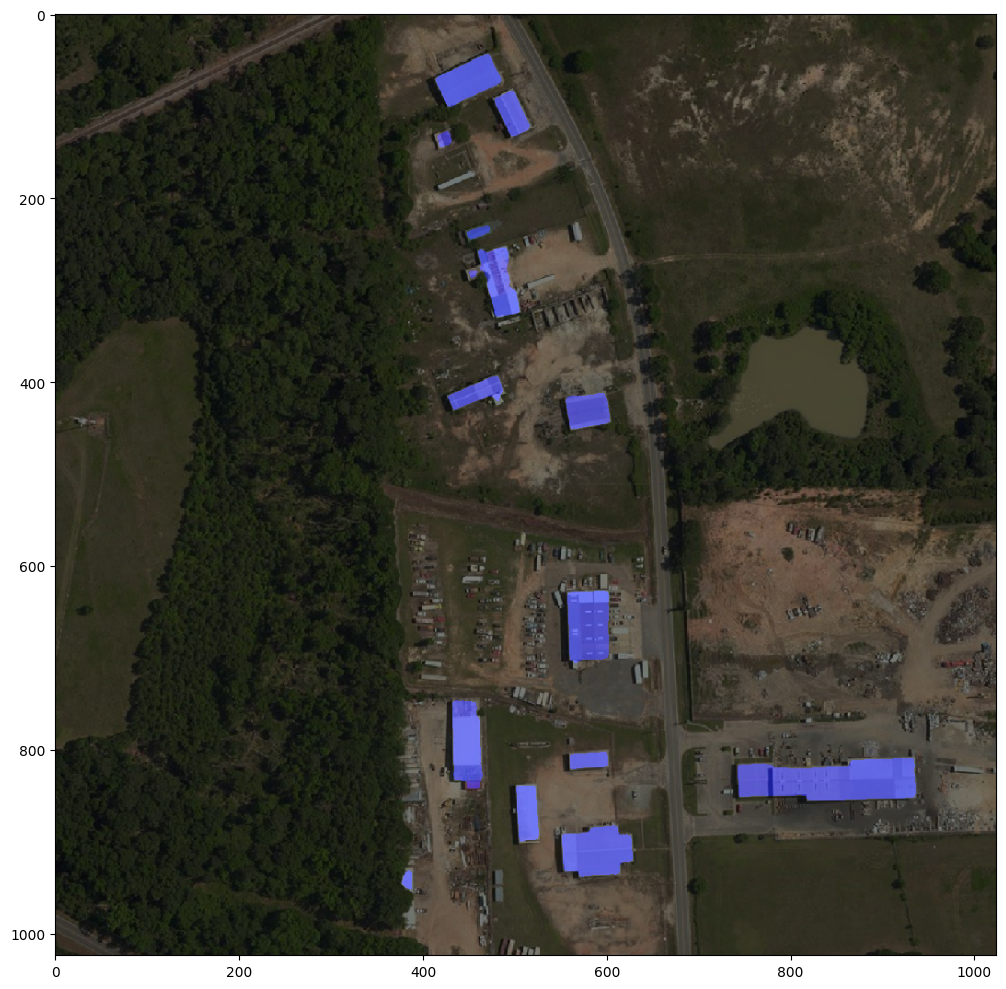

In [24]:
model.cfg = cfg

img = mmcv.imread('./train_img/TRAIN_1000.png')
result = inference_segmentor(model, img)
plt.figure(figsize=(10, 10))
show_result_pyplot(model, img, result, palette)

/home/cuvic/satellite/Segformer/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: mmsegmentation/building_checkpoint/iter_10000.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([2, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 720, 1, 1]).
size mismatch for decode_head.convs.0.conv.weight: copying a param with shape torch.Size([256, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([720, 720, 1, 1]).
size mismatch for decode_head.convs.0.bn.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([720]).
size mismatch for decode_head.convs.0.bn.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([720]).
size mismatch for decode_head.convs.0.bn.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([720]).
size mismatch for de

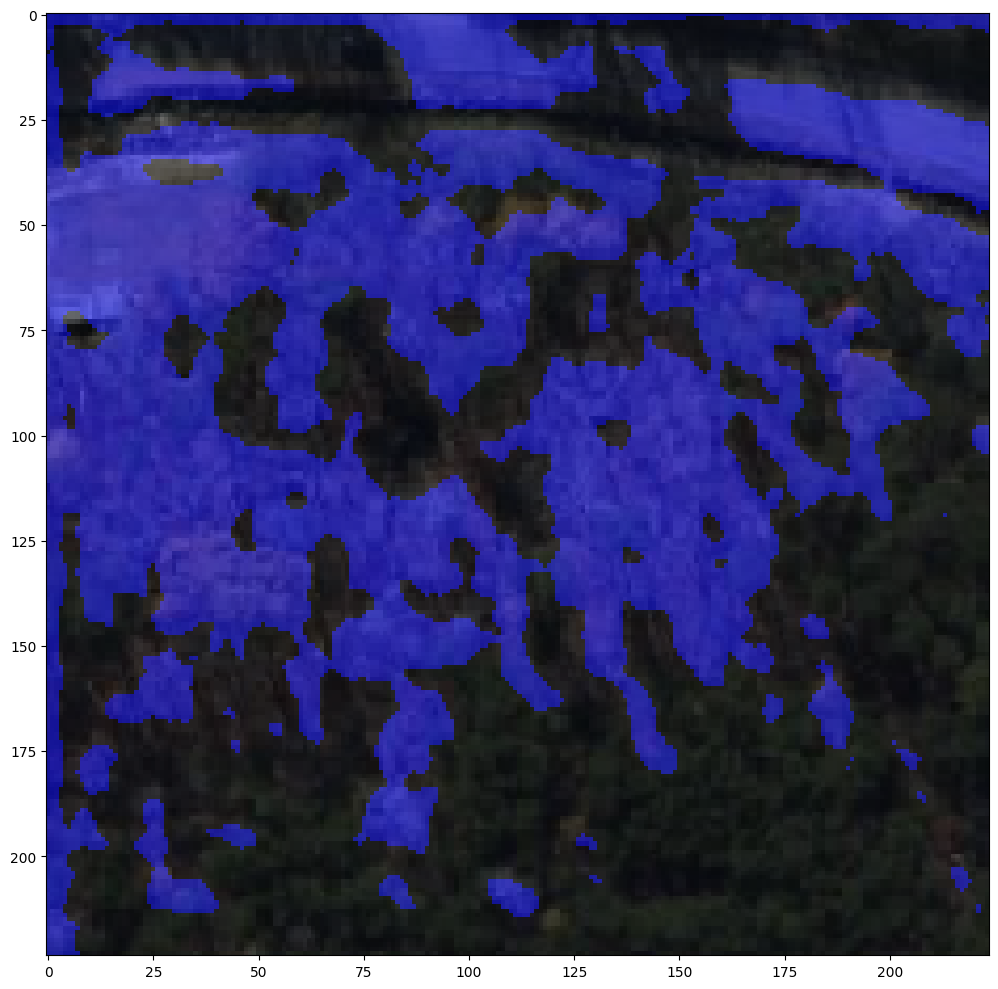

In [50]:
checkpoint_file = 'mmsegmentation/building_checkpoint/iter_10000.pth'  # 학습된 가중치 파일

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

In [ ]:
img = mmcv.imread('./test_img/TEST_20001.png') # inference할 이미지
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)